# Cab Industry Go-To-Market Insights 🚖

> **XYZ is a private equity firm in the US. Due to remarkable growth in the cab industry in the last few years, multiple key players in the market are planning for an investment in the cab industry.** 

> **This report acts as a guide for the company’s decision making process, helping uncover  insights and elaborating them for the company’s strategic decisions.**



In [1085]:
import pandas as pd
import datetime as dt
import xlrd
from plotnine import ggplot, geom_bar, facet_wrap, aes, facet_grid, labs, coord_flip, geom_hline, geom_line, stat_bin_2d
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [88]:
sns.set_palette("twilight_r")
sns.set_style("darkgrid")

# Data Loading and Initial Wrangling

In [570]:
cities = pd.read_csv("g2m_data/City.csv")
cities.head()

,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


In [89]:
payments = pd.read_csv('g2m_data/Transaction_ID.csv')
payments.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


In [90]:
customers = pd.read_csv('g2m_data/Customer_ID.csv')
customers.head()

,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [91]:
cab_data = pd.read_csv('g2m_data/Cab_Data.csv')
cab_data.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776


In [92]:
transactions = pd.merge(payments, customers, how='outer')
transactions.head()

,Transaction ID,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,29290,Card,Male,28,10813
1,10351127,29290,Cash,Male,28,10813
2,10412921,29290,Card,Male,28,10813
3,10000012,27703,Card,Male,27,9237
4,10320494,27703,Card,Male,27,9237


In [93]:
data = pd.merge(cab_data, transactions, how="outer")
data.tail()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
440093,10439406,NaN,NaN,NaN,NaN,NaN,NaN,23382,Card,Female,51,18919
440094,10439409,NaN,NaN,NaN,NaN,NaN,NaN,21420,Card,Female,18,4531
440095,10439413,NaN,NaN,NaN,NaN,NaN,NaN,49888,Card,Male,23,3226
440096,10439418,NaN,NaN,NaN,NaN,NaN,NaN,46456,Cash,Male,20,30662
440097,10439820,NaN,NaN,NaN,NaN,NaN,NaN,14971,Card,Male,30,15346


There are some missing values. `transactions` has 440k values, while `cab_data` only has 350k values. Since we have no information about trips that aren't in the cab_data dataset, we will have to drop these missing columns.

Some possible reasons:
- The data in `transactions` also includes customers that didn't make a trip (only customers who've filled in their user information and payment type information)
- Some cabs failed to register the trip data, thus causing the gap in transaction information and the trip information

Thus, the wrangled dataset becomes our main point of query.

In [94]:
data.dropna(inplace=True)
data.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,42377.0,Pink Cab,ATLANTA GA,30.45,370.95,313.635,29290,Card,Male,28,10813
1,10000012,42375.0,Pink Cab,ATLANTA GA,28.62,358.52,334.854,27703,Card,Male,27,9237
2,10000013,42371.0,Pink Cab,ATLANTA GA,9.04,125.20,97.632,28712,Cash,Male,53,11242
3,10000014,42376.0,Pink Cab,ATLANTA GA,33.17,377.40,351.602,28020,Cash,Male,23,23327
4,10000015,42372.0,Pink Cab,ATLANTA GA,8.73,114.62,97.776,27182,Card,Male,33,8536


# Data Cleaning and Wrangling

First, we shall de-serialize the excel serial dates using the `xlrd` library. But before that, we'll sort the dataset by the travel date.

In [95]:
def convert_to_date(date:float):
    """Converts an excel serial date to a python datetime object"""
    return xlrd.xldate_as_datetime(date, 0)

# Sort the dataset by the travel date
data = data.sort_values(by='Date of Travel')

#Apply the function to the 'date of travel' column
data['Date of Travel'] = data['Date of Travel'].apply(convert_to_date)

# Reset the index, since the sort shuffled the indices
data.reset_index(inplace=True, drop=True)

data.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10001340,2016-01-02,Yellow Cab,WASHINGTON DC,10.20,202.54,135.8640,52536,Card,Male,24,10606
1,10000640,2016-01-02,Yellow Cab,CHICAGO IL,15.60,374.66,209.6640,4844,Cash,Male,32,5548
2,10000635,2016-01-02,Yellow Cab,CHICAGO IL,25.08,532.83,337.0752,5671,Cash,Male,24,7081
3,10001001,2016-01-02,Yellow Cab,NEW YORK NY,46.80,1391.91,595.2960,2761,Card,Male,40,11462
4,10000171,2016-01-02,Pink Cab,SAN DIEGO CA,14.28,269.15,147.0840,20687,Cash,Male,39,8926


Then, we'll create a profit and profit ratio column in the dataset to make accessing it easier, since we're going to use it a lot in the analysis.

In [96]:
# Profit = Revenue - Cost
data['Profit'] = data['Price Charged'] - data['Cost of Trip']

# Profit Ratio = Profit / Revenue * 100
data['Profit Ratio'] = data['Profit'] / data['Cost of Trip'] * 100

# Profit per KM = Profit / KM travelled
data['Profit_KM'] = data['Profit'] / data['KM Travelled']

# Cost per KM = Cost of Trip / KM travelled
data['Price_KM'] = data['Price Charged'] / data['KM Travelled']

#Rounding up the results
data['Profit Ratio'] = data['Profit Ratio'].apply(lambda x: round(x, 2))
data['Profit_KM'] = data['Profit_KM'].apply(lambda x: round(x, 2))
data['Price_KM'] = data['Price_KM'].apply(lambda x: round(x, 2))


data.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Profit,Profit Ratio,Profit_KM,Price_KM
0,10001340,2016-01-02,Yellow Cab,WASHINGTON DC,10.20,202.54,135.8640,52536,Card,Male,24,10606,66.6760,49.08,6.54,19.86
1,10000640,2016-01-02,Yellow Cab,CHICAGO IL,15.60,374.66,209.6640,4844,Cash,Male,32,5548,164.9960,78.70,10.58,24.02
2,10000635,2016-01-02,Yellow Cab,CHICAGO IL,25.08,532.83,337.0752,5671,Cash,Male,24,7081,195.7548,58.07,7.81,21.25
3,10001001,2016-01-02,Yellow Cab,NEW YORK NY,46.80,1391.91,595.2960,2761,Card,Male,40,11462,796.6140,133.82,17.02,29.74
4,10000171,2016-01-02,Pink Cab,SAN DIEGO CA,14.28,269.15,147.0840,20687,Cash,Male,39,8926,122.0660,82.99,8.55,18.85


# Initial Analysis

In [403]:
aggs = pd.DataFrame(data.groupby('Company')[['Profit','Profit Ratio']].mean())
counts = pd.DataFrame(data['Company'].value_counts())
counts.rename({"Company":"Total Rides"}, inplace=True, axis=1)
concat = pd.concat([counts, aggs], axis=1)
concat.rename({"Profit":"Average Profit", "Profit Ratio":"Average Profit Ratio"}, axis=1, inplace=True)
concat[["Average Profit", "Average Profit Ratio"]].apply(lambda x: list(map(lambda y: f"${y:,.2f}", x)))

,Average Profit,Average Profit Ratio
Yellow Cab,$160.26,$54.30
Pink Cab,$62.65,$25.56


In [404]:
yellow_per_state = data[data['Company'] == 'Yellow Cab'].groupby('City').Company.count().reset_index()
yellow_per_state.rename({"Company":"Yellow Cab Rides"}, axis=1, inplace=True)

pink_per_state = data[data['Company'] == 'Pink Cab'].groupby('City').Company.count().reset_index()
pink_per_state.rename({"Company":"Pink Cab Rides"}, axis=1, inplace=True)

yellow_per_state_profit = data[data['Company'] == 'Yellow Cab'].groupby('City').Profit.sum().reset_index()
yellow_per_state_profit['Profit'] = yellow_per_state_profit['Profit'].map(lambda x: f"${x:,.2f}")
yellow_per_state_profit.rename({"Profit":"Yellow Cab Total Profit"}, inplace=True, axis=1)

pink_per_state_profit = data[data['Company'] == 'Pink Cab'].groupby('City').Profit.sum().reset_index()
pink_per_state_profit['Profit'] = pink_per_state_profit['Profit'].map(lambda x: f"${x:,.2f}")
pink_per_state_profit.rename({"Profit":"Pink Cab Total Profit"}, inplace=True, axis=1)


merge1 = pd.merge(yellow_per_state,yellow_per_state_profit, how='outer')
merge2 = pd.merge(pink_per_state,pink_per_state_profit, how='outer')

pd.merge(merge1, merge2, how='outer')

,City,Yellow Cab Rides,Yellow Cab Total Profit,Pink Cab Rides,Pink Cab Total Profit
0,ATLANTA GA,5795,"$746,382.81",1762,"$96,050.08"
1,AUSTIN TX,3028,"$379,255.74",1868,"$147,445.29"
2,BOSTON MA,24506,"$1,506,717.57",5186,"$262,001.70"
3,CHICAGO IL,47264,"$3,068,590.93",9361,"$318,722.49"
4,DALLAS TX,5637,"$1,104,003.15",1380,"$24,730.11"
5,DENVER CO,2431,"$357,000.07",1394,"$40,584.94"
6,LOS ANGELES CA,28168,"$3,285,976.58",19865,"$1,125,732.06"
7,MIAMI FL,4452,"$596,000.05",2002,"$162,301.19"
8,NASHVILLE TN,1169,"$85,247.68",1841,"$64,284.53"
9,NEW YORK NY,85918,"$26,451,080.77",13967,"$1,511,474.39"


Some key points:
- New York is both busy and expensive, being the city with the most profit generated and most rides served
- In New York, Yellow Cabs have 6x more trips than Pink Cabs, but generate around **25 times more profit** than their competitor
- In cities where there are more Pink Cab rides (Sacramento and San Diego just to name a few), Yellow Cab still generates much larger profits when compared head to head with their competitor.

---

# Profit Analysis

## Profit Ratio Analysis

**Question:** What are the expected distributions of profit ratios between the two companies?

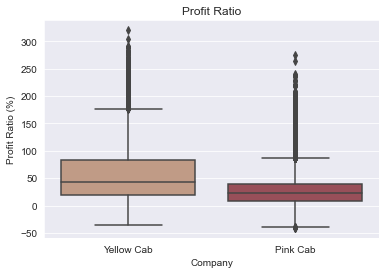

In [338]:
sns.boxplot(data=data, x="Company", y="Profit Ratio")

plt.title("Profit Ratio")
plt.ylabel("Profit Ratio (%)")
plt.show()

From the boxplot above, we can see that Yellow Cab rides have larger profit ratios (54% average) compared to Pink Cab rides (25% average).

In [100]:
months = data['Date of Travel'].dt.to_period('m')
per_month_profit = data.groupby([months, 'Company'])['Profit Ratio'].mean().reset_index()
months_string = per_month_profit['Date of Travel'].astype('str')
per_month_profit['Date of Travel'] = pd.to_datetime(months_string, infer_datetime_format=True)
per_month_profit

,Date of Travel,Company,Profit Ratio
0,2016-01-01,Pink Cab,31.716548
1,2016-01-01,Yellow Cab,75.107502
2,2016-02-01,Pink Cab,34.298343
3,2016-02-01,Yellow Cab,72.474114
4,2016-03-01,Pink Cab,28.729139
...,...,...,...
67,2018-10-01,Yellow Cab,44.424960
68,2018-11-01,Pink Cab,24.996074
69,2018-11-01,Yellow Cab,42.776854
70,2018-12-01,Pink Cab,30.667195


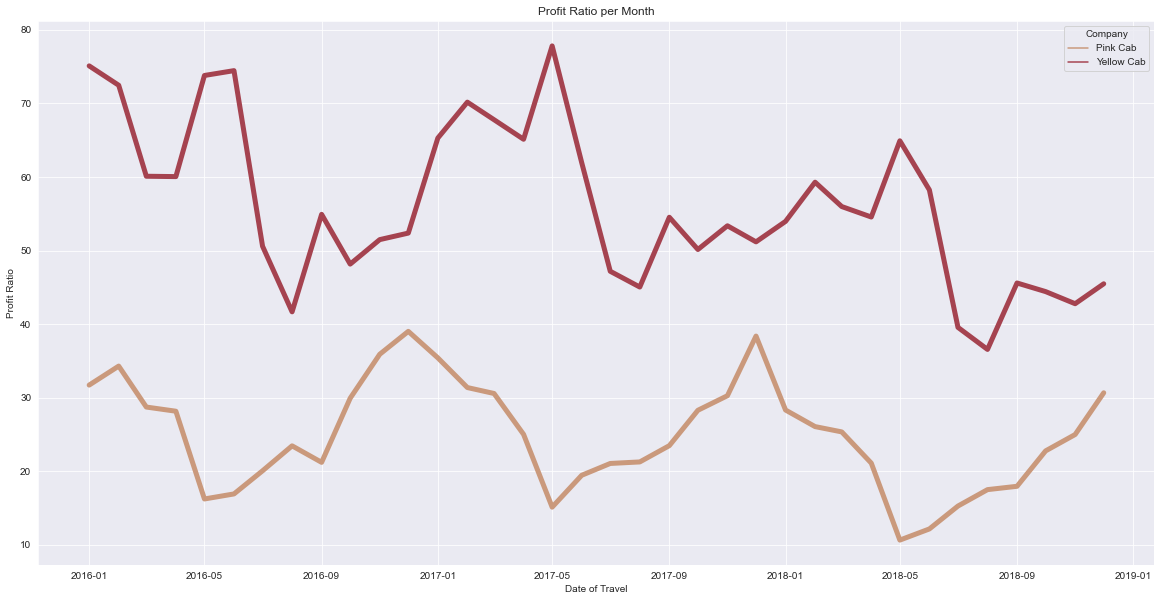

In [343]:
plt.figure(figsize=(20,10))

sns.lineplot(data=per_month_profit, x='Date of Travel', y='Profit Ratio', hue='Company', linewidth=5)
plt.title('Profit Ratio per Month')

plt.show()

Some insights:
- **Yellow Cab's** profit margins are experiencing a downward trend. From averaging a 75% profit ratio on 2016, now it just averages a profit ratio of 42%. In comparison, the **Pink Cab's** profit margins remain relatively stable, albeit some seasonal ups and downs, at around 34% after 2 years.
- **Yellow Cab** is most profitable around Q2 of each year, which is interestingly the same period where the **Pink Cab's** sales experience the most decline. This might tell us that customers from the Pink Cab tend to shift and use the Yellow Cab's services during this period of time.
- Meanwhile, **Pink Cab** has profit margins that increase during Q3 of the year. However, this peaks at around December and starts to decline in unison with the rise of **Yellow Cab**'s profit margins. After the peak, it is likely that the Yellow Cab starts to outcompete the Pink Cab, which explains the simultaneous increase and decline of their profit margins.

## Profit/km in different cities

**Question:** Which cities generate the most profit per km travelled?

/Users/garrethlee/miniconda3/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<Figure size 1152x720 with 0 Axes>

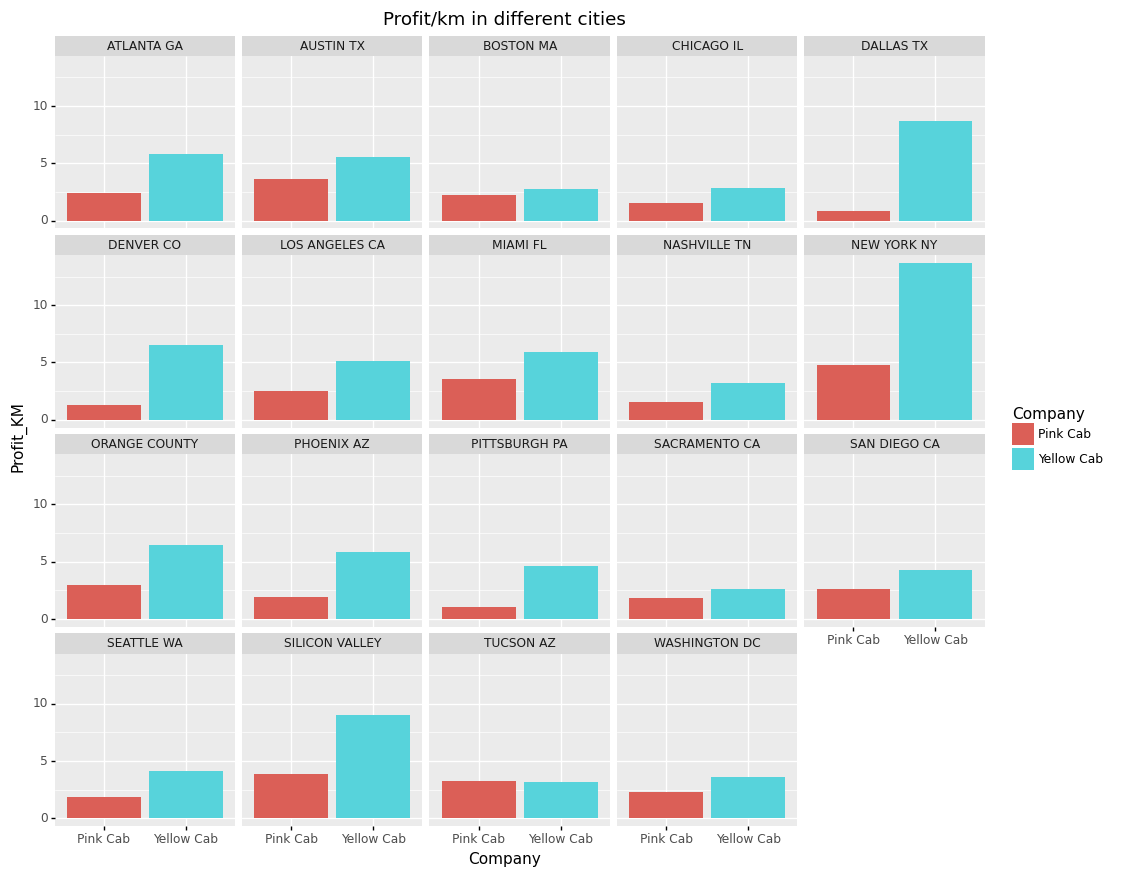

<ggplot: (707606748)>

In [699]:
plt.figure(figsize=(16,10))

city_profit_per_km = data.groupby(['City', 'Company'])['Profit_KM'].mean().reset_index().sort_values(by="Profit_KM")
city_profit_per_km_total = data.groupby('City')['Profit_KM'].mean().reset_index().sort_values(by="Profit_KM")

(ggplot(aes(x="Company", y="Profit_KM", fill="Company"), data=city_profit_per_km)) + geom_bar(stat="identity", position="dodge") + facet_wrap('~City') + labs(title="Profit/km in different cities")

**Some takeaways:** 
- The most profittable cities are New York, Silicon Valley, and Dallas
- Most of Yellow Cab's profit comes from New York, where it has the highest profit / km travelled
- Yellow Cab produces a higher profit / km in every city

## Day-of-the-week Customer Count Analysis

**Question:** Are some days of the week more profittable than others?

In [227]:
days = data['Date of Travel'].dt.dayofweek
days = days.map({i:day for i,day in list(enumerate(['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']))})
per_day = data.groupby([days, "Company"]).count()[['Transaction ID','Age']]
per_day = per_day.loc[['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']]
per_day.head()

Transaction ID    Age
Date of Travel Company                          
Sunday         Pink Cab              7032   7032
               Yellow Cab           22705  22705
Monday         Pink Cab              7077   7077
               Yellow Cab           22783  22783
Tuesday        Pink Cab              7076   7076

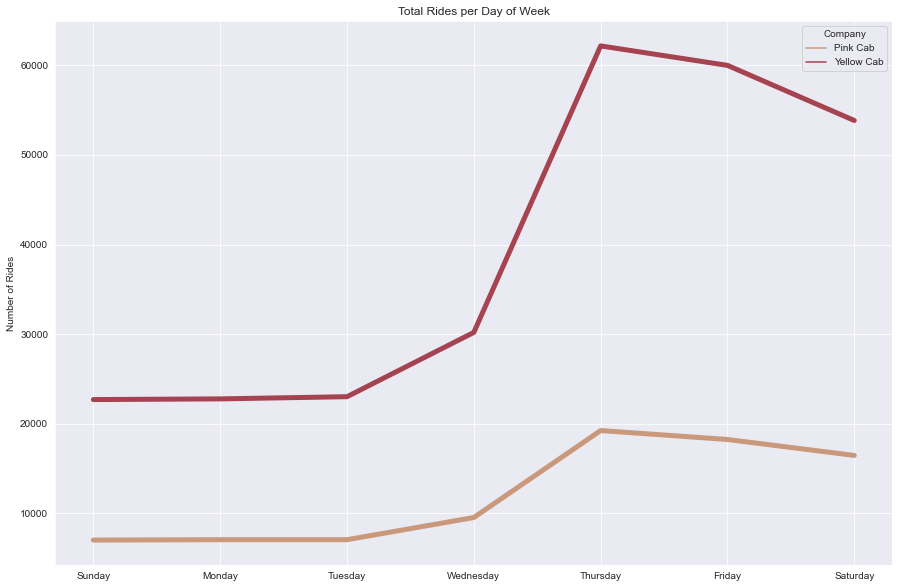

In [412]:
plt.figure(figsize=(15,10))

sns.lineplot(data=per_day, x="Date of Travel", y="Transaction ID", hue='Company', linewidth=5)
plt.title("Total Rides per Day of Week")
plt.xlabel("")
plt.ylabel("Number of Rides")
plt.show()

- Thursday is most popular day of the week
- Yellow Cab has more passengers in every day of the week

## Age Group Analysis

**Question:** Do some age groups generate more profit than others?

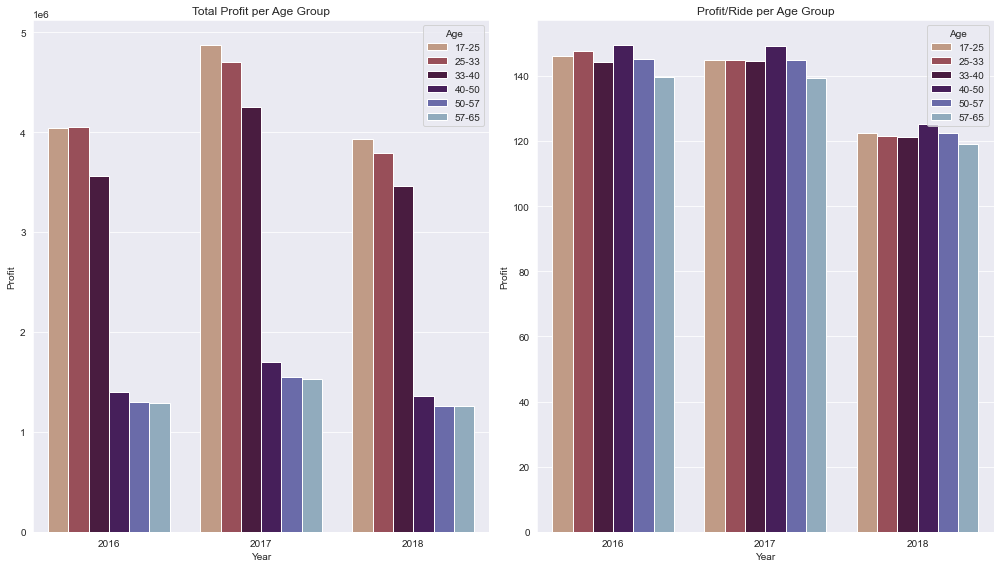

In [441]:
plt.figure(figsize=(14,8))

plt.subplot(121)
years = data['Date of Travel'].dt.year
age_bins = pd.cut(data['Age'], 6, labels=["17-25", "25-33", "33-40","40-50","50-57","57-65"])
ages = data.groupby([years, age_bins])["Profit"].sum().reset_index()
sns.barplot(data=ages, x="Date of Travel", y="Profit", hue="Age")
plt.xlabel("Year")
plt.title("Total Profit per Age Group")

plt.subplot(122)
years = data['Date of Travel'].dt.year
age_bins = pd.cut(data['Age'], 6, labels=["17-25", "25-33", "33-40","40-50","50-57","57-65"])
ages = data.groupby([years, age_bins])["Profit"].mean().reset_index()
sns.barplot(data=ages, x="Date of Travel", y="Profit", hue="Age")
plt.xlabel("Year")
plt.title("Profit/Ride per Age Group")


plt.tight_layout()
plt.show()

- Customers aged 17-25 were the most profittable age group. This is due to the fact that they are likely to take more trips overall than older age groups
- Younger customers (under 40) tend to be more profittable **overall** than older groups (over 40)
- People aged 40-45 tended to generate the largest profit **per-ride** for 3 consecutive years

In [487]:
age_city = pd.DataFrame(data.groupby(["City",age_bins, "Company"])["Transaction ID"].count()).reset_index()
age_city.rename({"Transaction ID":"Total Rides"}, axis=1, inplace=True)

age_city.head()

,City,Age,Company,Total Rides
0,ATLANTA GA,17-25,Pink Cab,461
1,ATLANTA GA,17-25,Yellow Cab,1573
2,ATLANTA GA,25-33,Pink Cab,429
3,ATLANTA GA,25-33,Yellow Cab,1360
4,ATLANTA GA,33-40,Pink Cab,424


/Users/garrethlee/miniconda3/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


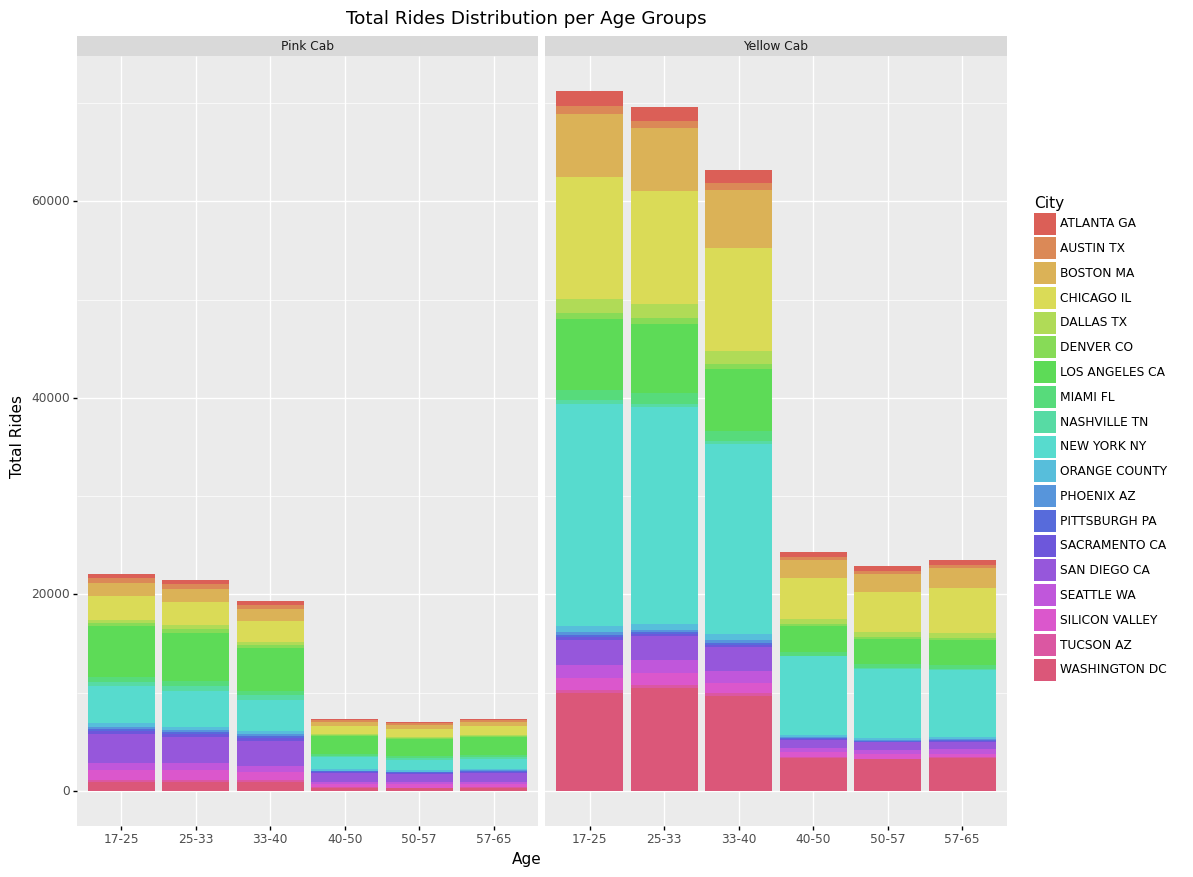

<ggplot: (723311758)>

In [630]:
plotnine.options.figure_size = (12, 10)

(ggplot(aes(x="Age", y="Total Rides", fill="City"), data=age_city)) + geom_bar(stat="identity") + facet_grid('~Company') + labs(title="Total Rides Distribution per Age Groups")


- Pink Cab customers are mostly from LA
- Most Yellow Cab customers reside in New York (which is where most of their profit comes from)

# Payment Mode Analysis

**Question:** Does paying by card or cash affect the amount of profit generated?

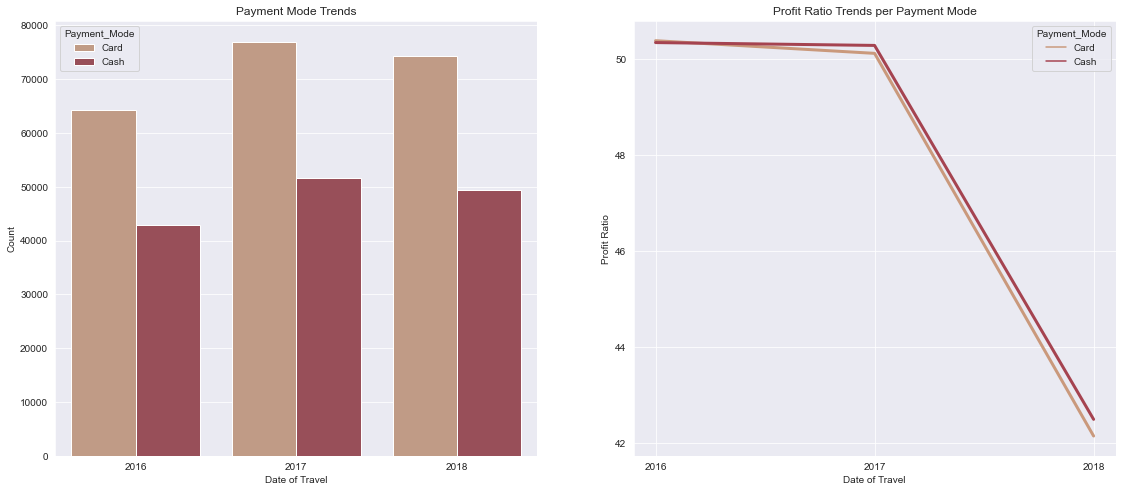

In [1101]:
plt.figure(figsize=(19,8))

plt.subplot(121)
payment = data.groupby([years, "Payment_Mode"])["Transaction ID"].count().reset_index()
sns.barplot(x="Date of Travel", y="Transaction ID", hue="Payment_Mode", data=payment)

plt.ylabel("Count")
plt.title("Payment Mode Trends")

plt.subplot(122)
profit = data.groupby([years, "Payment_Mode"])["Profit Ratio"].mean().reset_index()
sns.lineplot(x="Date of Travel", y="Profit Ratio", hue="Payment_Mode", data=profit, linewidth=3)

plt.ylabel("Profit Ratio")
plt.xticks([2016,2017,2018])
plt.title("Profit Ratio Trends per Payment Mode")

plt.show()

The data above shows that people increasingly use cards instead of cash as a method of payment. The more frequent use of cards as a method of payment, however, doesn't affect the profits earned with respect to the method of payment used. From the graph on the right, we can see that the average profit ratio was similar between card payments and cash payments, indicating that there is no outstanding difference between card and cash payments that would affect profit greatly.

# Unique Customers Analysis

**Question** What attributes do customers of each company possess?

In [1007]:
unique_customers = pd.DataFrame(data.groupby(["City","Company"])['Customer ID'].unique()).reset_index()
unique_customers['Customer ID'] = unique_customers['Customer ID'].apply(lambda x: len(x))
unique_customers.rename({"Customer ID":"Unique Customers"}, axis=1, inplace=True)
unique_customers.head()

,City,Company,Unique Customers
0,ATLANTA GA,Pink Cab,1322
1,ATLANTA GA,Yellow Cab,2595
2,AUSTIN TX,Pink Cab,1354
3,AUSTIN TX,Yellow Cab,1914
4,BOSTON MA,Pink Cab,2463


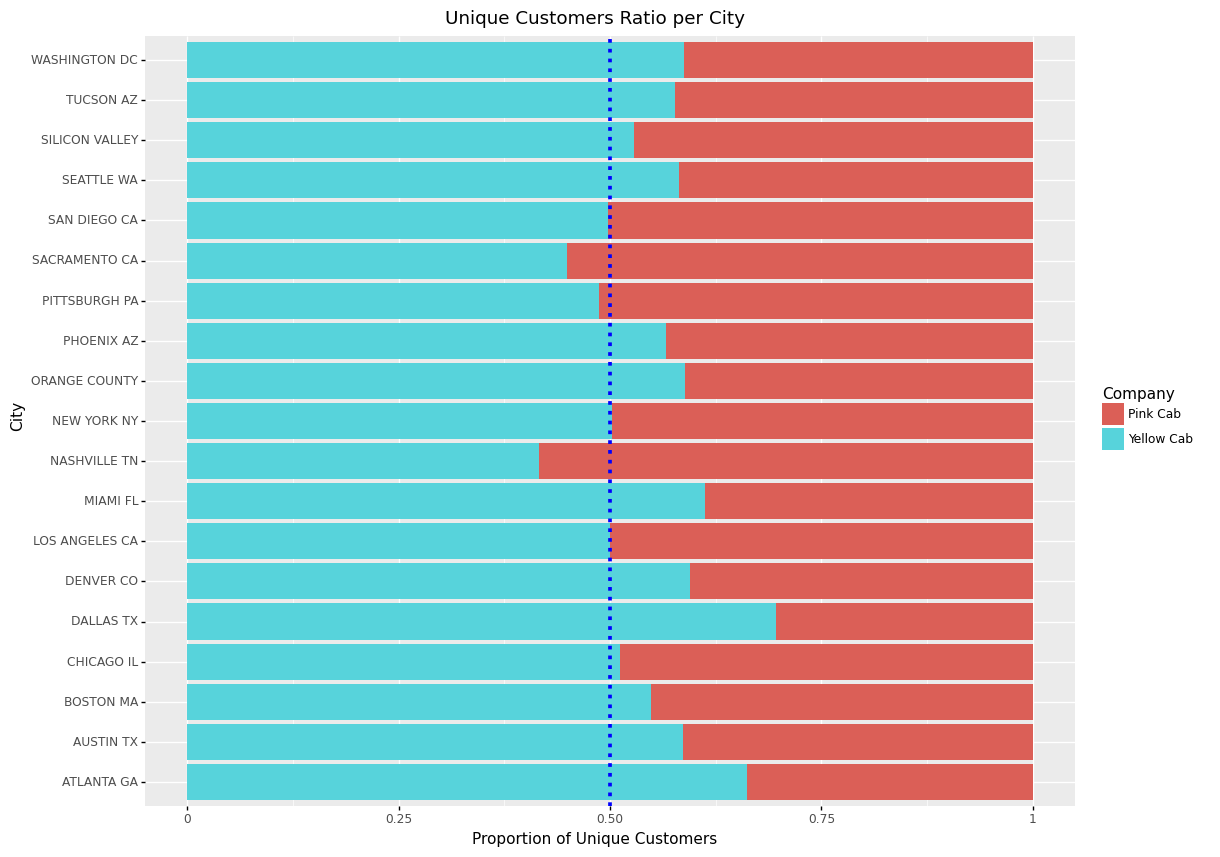

<ggplot: (711903416)>

In [642]:
(ggplot(aes(x="City", y="Unique Customers", fill="Company"), data=unique_customers)) + geom_bar(stat='identity', position="fill") + coord_flip() + geom_hline(yintercept = 0.5, linetype="dotted", 
                color = "blue", size=1.5) + labs(y="Proportion of Unique Customers", title="Unique Customers Ratio per City")

**Few key points:**
- While New York has more than 4x Yellow Cab rides to Pink Cab Rides, there are equal numbers of unique customers from each area. This is likely due to most Yellow Cab customers in New York being regulars who use yellow cabs frequently.
- Yellow Cab has more unique customers in all cities, except for Nashville, Pittsburgh, and Sacramento. However, profit in these cities are more than what Pink Cab generates, despite having less unique customers.

## Regular Customers Analysis

For these purposes, we will assume **regular** customers to be customers who have taken 10 or more trips with the same company

---
**Question:** Does lower prices increase customer retention (cause them to travel more with the same company)?

In [832]:
yellow_customers = data[data["Company"] == "Yellow Cab"]
yellow_counts = yellow_customers["Customer ID"].value_counts()
dedicated_yellow_customers = yellow_counts[yellow_counts >= 10]
yellow_dedicated = yellow_customers[yellow_customers["Customer ID"].isin(dedicated_yellow_customers.index)]

pink_customers = data[data["Company"] == "Pink Cab"]
pink_counts = pink_customers["Customer ID"].value_counts()
dedicated_pink_customers = pink_counts[pink_counts >= 10]
pink_dedicated = pink_customers[pink_customers["Customer ID"].isin(dedicated_pink_customers.index)]

In [692]:
print(f"Number of unique regular customers for Yellow Cab: {len(yellow_dedicated['Customer ID'].unique())}")
print(f"Number of unique regular customers for Pink Cab: {len(pink_dedicated['Customer ID'].unique())}")

Number of unique regular customers for Yellow Cab: 10715
Number of unique regular customers for Pink Cab: 492


Yellow Cab has way more regular customers than Pink Cab.

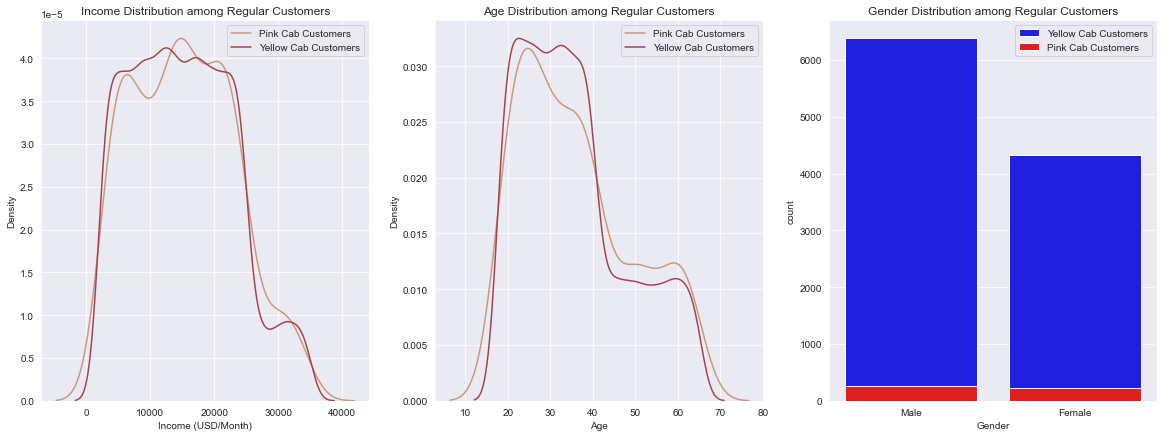

In [846]:
unique_pink_dedicated = pink_dedicated['Customer ID'].unique()
pink_regular_demographics = customers[customers["Customer ID"].isin(unique_pink_dedicated)]

unique_yellow_dedicated = yellow_dedicated['Customer ID'].unique()
yellow_regular_demographics = customers[customers["Customer ID"].isin(unique_yellow_dedicated)]

plt.figure(figsize=(20,7))

plt.subplot(131)
sns.kdeplot(data=pink_regular_demographics, x="Income (USD/Month)", label="Pink Cab Customers")
sns.kdeplot(data=yellow_regular_demographics, x="Income (USD/Month)", label="Yellow Cab Customers")

plt.title("Income Distribution among Regular Customers")
plt.legend()

plt.subplot(132)
sns.kdeplot(data=pink_regular_demographics, x="Age", label="Pink Cab Customers")
sns.kdeplot(data=yellow_regular_demographics, x="Age", label="Yellow Cab Customers")

plt.title("Age Distribution among Regular Customers")
plt.legend()

plt.subplot(133)
sns.countplot(data=yellow_regular_demographics, x="Gender", label="Yellow Cab Customers", color="b")
sns.countplot(data=pink_regular_demographics, x="Gender", label="Pink Cab Customers", color="r")
plt.title("Gender Distribution among Regular Customers")
plt.legend()


plt.show()

> Regulars for Yellow Cab and Pink Cab both have similar distributions in income, gender, and age, with slightly more people in ages 20-40 taking yellow cabs compared to pink cabs

Now, let's once again verify the prices charged against regular customers and see if their patterns compare to all customers.

In [845]:
yellow_means = pd.DataFrame(yellow_dedicated.mean(numeric_only=True)).astype(int).reset_index()
pink_means = pd.DataFrame(pink_dedicated.mean(numeric_only=True)).astype(int).reset_index()
yellow_means.rename({0:"Regular Yellow Cab Customers Avg Value"}, axis=1, inplace=True)
pink_means.rename({0:"Regular Pink Cab Customers Avg Value"}, axis=1, inplace=True)
pink_and_yellow_means = pd.merge(yellow_means, pink_means)
pink_and_yellow_means[pink_and_yellow_means['index'].isin(["Transaction ID", "Customer ID"]) == False]

,index,Regular Yellow Cab Customers Avg Value,Regular Pink Cab Customers Avg Value
1,KM Travelled,22,22
2,Price Charged,477,310
3,Cost of Trip,298,248
5,Age,35,36
6,Income (USD/Month),15044,15195
7,Profit,178,61
8,Profit Ratio,60,25
9,Profit_KM,7,2
10,Price_KM,21,13


On average, Yellow Cab regulars pay 40% more than Pink Cab customers per km (`Price_KM`), despite riding the same distance on average (`KM Travelled`). This also results in Yellow Cab earning 3.5x profit / km compared to Pink Cab (`Profit_KM`). However, the higher prices don't seem to dissuade customers, as the table a few cells above shows that there are much more unique Yellow Cab customers compared to Pink Cab customers.

So, it seems that cheaper cab prices don't influence customer retention.

# Customer Reach Analysis

**Question:** How many unique customers can each company reach?

In [990]:
sum(data["City"] == "SAN FRANSISCO CA")

0

Since neither companies have had trips in San Francisco, we can drop the city for our reach analysis

In [1002]:
# Drop SF from the table
cities = cities.drop(cities[cities.City == "SAN FRANCISCO CA"].index, axis=0)

In [1014]:
customers_per_city = list(map(int, [count for counts in [[c.replace(',','').strip()]*2 for c in cities.sort_values(by="City")['Users']] for count in counts]))
customer_reach = unique_customers.copy()
customer_reach["Unique Customers"] = customer_reach["Unique Customers"] / customers_per_city * 100
customer_reach.rename({"Unique Customers":"% of Cab Users Reached"}, inplace=True, axis=1)
customer_reach.head()

,City,Company,% of Cab Users Reached
0,ATLANTA GA,Pink Cab,5.352010
1,ATLANTA GA,Yellow Cab,10.505648
2,AUSTIN TX,Pink Cab,9.039925
3,AUSTIN TX,Yellow Cab,12.778742
4,BOSTON MA,Pink Cab,3.077942


/Users/garrethlee/miniconda3/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


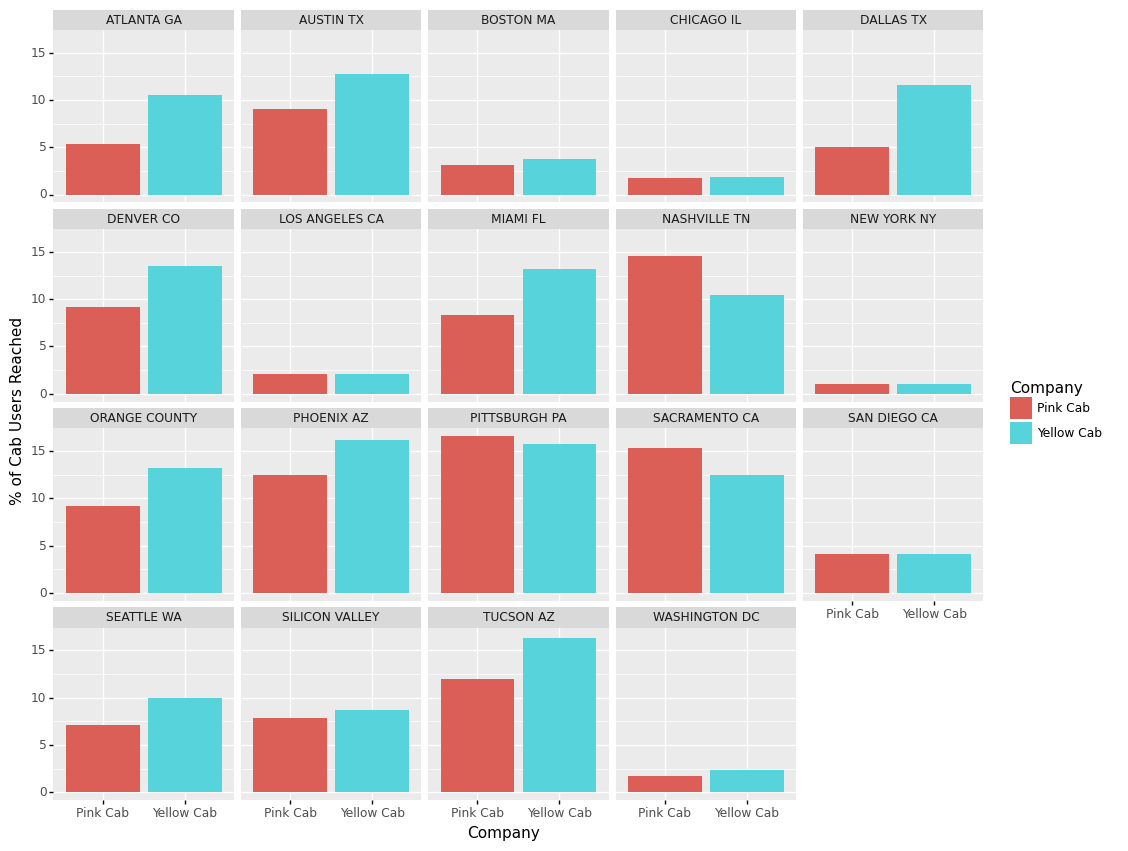

<ggplot: (743129938)>

In [1096]:
(ggplot(aes(x="Company",y="% of Cab Users Reached", fill="Company"), data=customer_reach)) + geom_bar(stat='identity') + facet_wrap("~City")

**Few key points:**
- On average, both companies reached around 8% of the cab user population in each city
- In most cities, yellow cab is able to reach more of the cab users than pink cab


In [1099]:
customer_reach.groupby("Company")["% of Cab Users Reached"].mean()

Company
Pink Cab      7.675298
Yellow Cab    9.461955
Name: % of Cab Users Reached, dtype: float64

> On average, Yellow Cab reaches 2% more customers than Pink Cab in each city.

# Summary and Recommendations 📈

Based on the analysis above, we have determined that `Yellow Cab` company would be a better investment choice based on the following metrics:
- **Profit Ratio**: Yellow Cab consistently produces larger profits and trends show that Pink Cab's profit ratios have been stagnant these past 3 years
- **Customer Reach**: Yellow Cab has greater reach in almost all cities
- **Profit/Km**: Despite charging higher than Pink Cab per km travelled, Yellow Cab still attracts more customers and generates more profit per km.
- **Customer Retention**: There are 20x more regular Yellow Cab customers than Pink Cab customers.
- **Targeted Market**: In areas where the price charged is higher (`Price_KM`), Yellow Cabs have much more rides compared to Pink Cabs, equating to an even greater difference in profit.

However, there are some things to consider:
- **Decreasing Profit Ratio**: While Yellow Cab profit ratios have mainly been larger than Pink Cab's, Yellow Cab's average profit ratios have seen a diminishing trend compared to previous years (75% in 2016 to 34% in 2018)


---

Overall, we highly recommend investing in Yellow Cab, with an emphasis on the following aspects:
- Invest in card payment methods
- Target marketing towards 20-40 year olds
- Invest in high profit/km areas, such as New York and Dallas